Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Collected 20/100 trajectories
Collected 40/100 trajectories
Collected 60/100 trajectories
Collected 80/100 trajectories
Collected 100/100 trajectories

Reward statistics:
  Mean: 0.100
  Min: 0.100
  Max: 0.100

Training with Trajectory Balance Loss
Epoch 1/50: Loss = 15.9088, logZ = 0.0843
Epoch 10/50: Loss = 4.8171, logZ = 0.8016
Epoch 20/50: Loss = 2.0787, logZ = 1.5286
Epoch 30/50: Loss = 0.6975, logZ = 2.1348
Epoch 40/50: Loss = 0.1537, logZ = 2.5856
Epoch 50/50: Loss = 0.0235, logZ = 2.8599

Training complete
Final Loss: 0.0235
Final logZ: 2.8599
Final Z: 17.4607


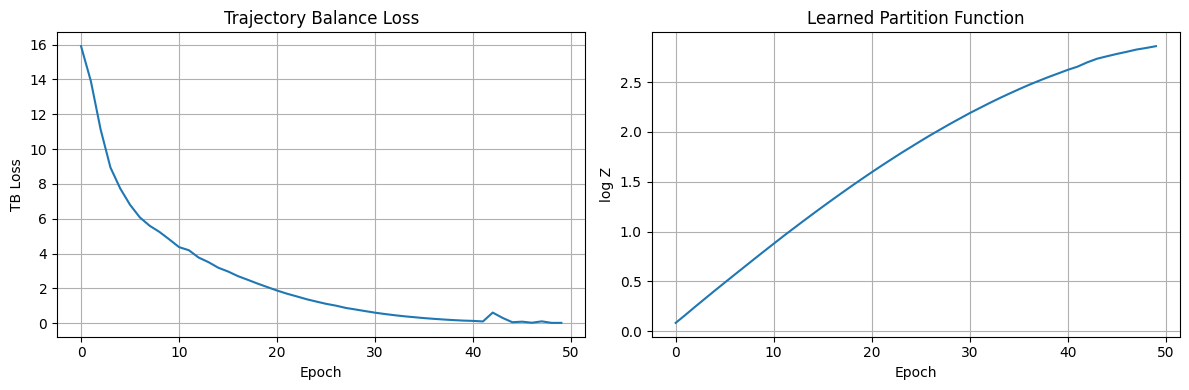

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from gfn_environments.single_color_ramp import *

class GFlowNetWithZ(nn.Module):
    """GFlowNet model with learned partition function Z"""
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        # Learned partition function
        self.logZ = nn.Parameter(torch.tensor(0.0))

    def forward(self, state_tensor: torch.Tensor, action_mask: torch.Tensor) -> torch.Tensor:
        logits = self.net(state_tensor)
        # Mask invalid actions
        logits = logits.masked_fill(~action_mask, float('-inf'))
        return torch.softmax(logits, dim=-1)


def compute_variance_reward(heightmap: torch.Tensor, target_min: float = 0.3, target_max: float = 0.7) -> float:
    """Reward based on variance being in target range"""
    variance = heightmap.var().item()

    if target_min <= variance <= target_max:
        return 1.0  # Perfect
    elif variance < target_min:
        return max(0.1, variance / target_min)  # Minimum 0.1
    else:  # variance > target_max
        return max(0.1, 1.0 - (variance - target_max))  # Minimum 0.1


def collect_trajectories_with_rewards(num_trajectories: int = 100, traj_length: int = 5):
    """Collect trajectories and compute their final rewards"""
    load_blend_single_color_ramp()
    blender_api = BlenderTerrainAPI()

    print("=" * 60)
    print("Collecting trajectories with rewards")
    print("=" * 60)

    trajectories = []

    for traj_idx in range(num_trajectories):
        initial_state = StepWExperimentDefinition.base_environment_state(blender_api)
        trajectory = StepWExperimentDefinition.Trajectory(blender_api, initial_state=initial_state)

        traj_data = {
            'states': [],
            'actions': [],
            'masks': [],
            'reward': 0.0
        }

        for step_idx in range(traj_length):
            state_tensor = trajectory.get_state_tensor().clone()
            action_mask = trajectory.get_action_mask().clone()

            traj_data['states'].append(state_tensor)
            traj_data['masks'].append(action_mask)

            # Random action (excluding stop until last step)
            if step_idx == traj_length - 1:
                stop_offset = StepWExperimentDefinition.get_action_offset('stop')
                action_idx = stop_offset
            else:
                valid_actions = []
                step_w_offset = StepWExperimentDefinition.get_action_offset('step_w')
                if action_mask[step_w_offset]:
                    valid_actions.append(step_w_offset)

                step_scale_offset = StepWExperimentDefinition.get_action_offset('step_scale')
                if action_mask[step_scale_offset]:
                    valid_actions.append(step_scale_offset)

                color_offset = StepWExperimentDefinition.get_action_offset('add_color')
                for i in range(len(StepWExperimentDefinition.VALID_COLOR_INDICES)):
                    if action_mask[color_offset + i]:
                        valid_actions.append(color_offset + i)

                action_idx = valid_actions[torch.randint(len(valid_actions), (1,)).item()]

            traj_data['actions'].append(action_idx)

            action = StepWExperimentDefinition.Action.from_flat_index(action_idx)
            trajectory.step(action, reward=0.0)

        # Compute final reward
        heightmap = blender_api.get_heightmap()
        reward = compute_variance_reward(heightmap)
        traj_data['reward'] = reward

        trajectories.append(traj_data)

        if (traj_idx + 1) % 20 == 0:
            print(f"Collected {traj_idx + 1}/{num_trajectories} trajectories")

    # Print reward statistics
    rewards = [t['reward'] for t in trajectories]
    print(f"\nReward statistics:")
    print(f"  Mean: {sum(rewards) / len(rewards):.3f}")
    print(f"  Min: {min(rewards):.3f}")
    print(f"  Max: {max(rewards):.3f}")

    return trajectories


def train_gflownet_with_tb_loss(trajectories, num_epochs: int = 50):
    """Train with proper Trajectory Balance loss"""

    state_dim = StepWExperimentDefinition.State.get_state_dim()
    action_dim = StepWExperimentDefinition.State.get_action_dim()

    model = GFlowNetWithZ(state_dim, action_dim, hidden_dim=256)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("\n" + "=" * 60)
    print("Training with Trajectory Balance Loss")
    print("=" * 60)

    epoch_losses = []
    epoch_logZs = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        valid_trajectories = 0

        # Shuffle trajectories
        indices = torch.randperm(len(trajectories))

        for idx in indices:
            traj = trajectories[idx]

            if len(traj['states']) < 1:
                continue

            # Forward path: logZ + Σ log P_F
            log_forward = model.logZ
            valid_trajectory = True

            for state, action, mask in zip(traj['states'], traj['actions'], traj['masks']):
                action_probs = model(state, mask)

                if action_probs[action] > 0:
                    log_forward = log_forward + torch.log(action_probs[action] + 1e-8)
                else:
                    valid_trajectory = False
                    break

            if not valid_trajectory:
                continue

            # Backward path: log R
            reward = traj['reward']
            if reward <= 0:
                reward = 1e-8

            log_backward = torch.log(torch.tensor(reward, dtype=torch.float32))

            # Trajectory Balance loss: (log Z + Σ log P_F - log R)²
            loss = (log_forward - log_backward) ** 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            valid_trajectories += 1

        if valid_trajectories > 0:
            avg_loss = total_loss / valid_trajectories
        else:
            avg_loss = 0.0

        epoch_losses.append(avg_loss)
        epoch_logZs.append(model.logZ.item())

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}: Loss = {avg_loss:.4f}, logZ = {model.logZ.item():.4f}")

    print("\n" + "=" * 60)
    print("Training complete")
    print("=" * 60)
    print(f"Final Loss: {epoch_losses[-1]:.4f}")
    print(f"Final logZ: {epoch_logZs[-1]:.4f}")
    print(f"Final Z: {torch.exp(torch.tensor(epoch_logZs[-1])).item():.4f}")

    # Plot learning curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(epoch_losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('TB Loss')
    ax1.set_title('Trajectory Balance Loss')
    ax1.grid(True)

    ax2.plot(epoch_logZs)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('log Z')
    ax2.set_title('Learned Partition Function')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('./tests/file_dump/gflownet_tb_training.png', dpi=150)
    plt.show()

    return model, epoch_losses, epoch_logZs


# Run full training pipeline
trajectories = collect_trajectories_with_rewards(num_trajectories=100, traj_length=5)
model, losses, logZs = train_gflownet_with_tb_loss(trajectories, num_epochs=50)

STEP 1: Collect trajectories
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Collected 20/100 trajectories
Collected 40/100 trajectories
Collected 60/100 trajectories
Collected 80/100 trajectories
Collected 100/100 trajectories

Reward statistics:
  Mean: 0.100
  Min: 0.100
  Max: 0.100

STEP 2: Analyze reward signal

TRAJECTORY REWARD ANALYSIS

Total trajectories: 100

Reward statistics:
  Mean: 0.100
  Std:  0.000
  Min:  0.100
  Max:  0.100

Reward distribution:
  High   (≥0.8):   0 (0.0%)
  Medium (0.5-0.8):   0 (0.0%)
  Low    (<0.5): 100 (100.0%)

Signal strength:
  Perfect (1.0):      0 (0.0%)
  Strong  (≥0.9):     0 (0.0%)
  Weak    (<0.2):   100 (100.0%)
  Useful signal:      

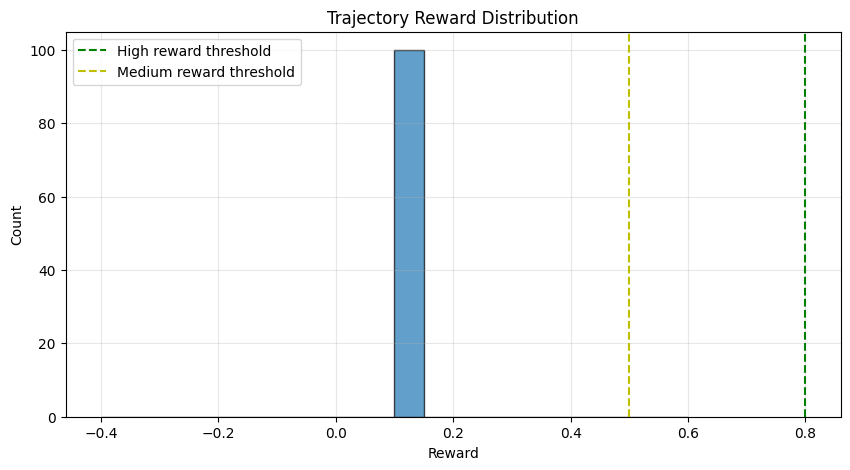


STEP 3: Train model

Training with Trajectory Balance Loss
Epoch 1/50: Loss = 17.9756, logZ = 0.0909
Epoch 10/50: Loss = 5.0746, logZ = 0.7981
Epoch 20/50: Loss = 2.1332, logZ = 1.5195
Epoch 30/50: Loss = 0.7115, logZ = 2.1251
Epoch 40/50: Loss = 0.1574, logZ = 2.5756
Epoch 50/50: Loss = 0.0154, logZ = 2.8553

Training complete
Final Loss: 0.0154
Final logZ: 2.8553
Final Z: 17.3794


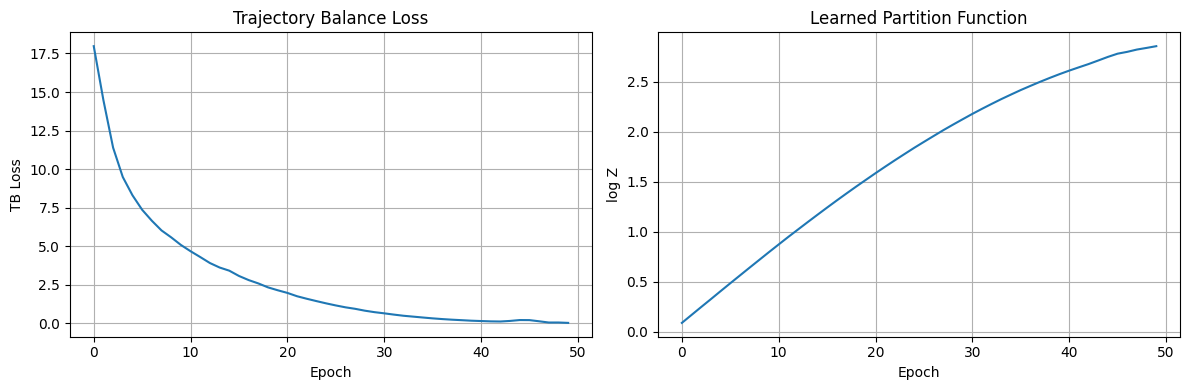


STEP 4: Sample from trained model
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend

SAMPLING 10 TRAJECTORIES FROM MODEL

--- Sampling Trajectory 1 ---
  Step 1: add_color (log_prob: -0.478)
  Step 2: step_scale (log_prob: -1.051)
  Step 3: step_w (log_prob: -2.698)
  Step 4: add_color (log_prob: -1.288)
  Step 5: stop (log_prob: -1.025)
  Final variance: 0.0013
  Final reward: 0.100
Fra:1 Mem:55.37M (Peak 55.37M) | Time:00:00.40 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.44 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.48 | Rendering 50 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.50 | Rendering 64 / 64 samples
Saved: 't

In [5]:
import os
def screenshot_viewport_to_png(filepath: str, resolution_x: int = 800, resolution_y: int = 600):
    """
    Quick render of the scene from a default viewpoint (no camera setup needed).

    Args:
        filepath: Path where the PNG should be saved (e.g., "./output/screenshot.png")
        resolution_x: Width of the image in pixels
        resolution_y: Height of the image in pixels
    """
    # Ensure directory exists
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    scene = bpy.context.scene

    # Store original settings
    original_camera = scene.camera
    original_engine = scene.render.engine

    # Create a temporary camera if none exists
    camera_data = bpy.data.cameras.new(name="TempCamera")
    camera_object = bpy.data.objects.new("TempCamera", camera_data)
    bpy.context.collection.objects.link(camera_object)

    # Position camera to view the mesh (adjust these values as needed)
    camera_object.location = (7, -7, 5)
    camera_object.rotation_euler = (1.1, 0, 0.785)

    # Set as active camera
    scene.camera = camera_object

    # Add lighting - Sun light for overall illumination
    sun_data = bpy.data.lights.new(name="TempSun", type='SUN')
    sun_data.energy = 3.0  # Brightness
    sun_object = bpy.data.objects.new("TempSun", sun_data)
    bpy.context.collection.objects.link(sun_object)
    sun_object.location = (5, 5, 10)
    sun_object.rotation_euler = (0.7, 0.3, 0)

    # Add fill light for better visibility
    fill_data = bpy.data.lights.new(name="TempFill", type='AREA')
    fill_data.energy = 100.0
    fill_data.size = 5.0
    fill_object = bpy.data.objects.new("TempFill", fill_data)
    bpy.context.collection.objects.link(fill_object)
    fill_object.location = (-5, -5, 8)
    fill_object.rotation_euler = (1.2, 0, -0.785)

    # Configure render settings for quick preview
    scene.render.engine = 'BLENDER_EEVEE_NEXT'  # Fast rendering (Blender 4.x)
    scene.render.image_settings.file_format = 'PNG'
    scene.render.filepath = filepath
    scene.render.resolution_x = resolution_x
    scene.render.resolution_y = resolution_y
    scene.render.resolution_percentage = 100

    # Quick render
    bpy.ops.render.render(write_still=True)

    # Cleanup: remove temporary objects
    bpy.data.objects.remove(camera_object, do_unlink=True)
    bpy.data.cameras.remove(camera_data)
    bpy.data.objects.remove(sun_object, do_unlink=True)
    bpy.data.lights.remove(sun_data)
    bpy.data.objects.remove(fill_object, do_unlink=True)
    bpy.data.lights.remove(fill_data)

    # Restore original settings
    scene.camera = original_camera
    scene.render.engine = original_engine

    print(f"Viewport screenshot saved to: {filepath}")

def analyze_trajectory_rewards(trajectories):
    """Analyze reward distribution in collected trajectories"""
    rewards = [t['reward'] for t in trajectories]

    print("\n" + "=" * 60)
    print("TRAJECTORY REWARD ANALYSIS")
    print("=" * 60)

    # Basic statistics
    print(f"\nTotal trajectories: {len(trajectories)}")
    print(f"\nReward statistics:")
    print(f"  Mean: {sum(rewards) / len(rewards):.3f}")
    print(f"  Std:  {torch.tensor(rewards).std().item():.3f}")
    print(f"  Min:  {min(rewards):.3f}")
    print(f"  Max:  {max(rewards):.3f}")

    # Categorize rewards
    high_reward = sum(1 for r in rewards if r >= 0.8)
    medium_reward = sum(1 for r in rewards if 0.5 <= r < 0.8)
    low_reward = sum(1 for r in rewards if r < 0.5)

    print(f"\nReward distribution:")
    print(f"  High   (≥0.8): {high_reward:3d} ({high_reward/len(rewards)*100:.1f}%)")
    print(f"  Medium (0.5-0.8): {medium_reward:3d} ({medium_reward/len(rewards)*100:.1f}%)")
    print(f"  Low    (<0.5): {low_reward:3d} ({low_reward/len(rewards)*100:.1f}%)")

    # Signal analysis
    perfect_signal = sum(1 for r in rewards if r == 1.0)
    strong_signal = sum(1 for r in rewards if r >= 0.9)
    weak_signal = sum(1 for r in rewards if r < 0.2)

    print(f"\nSignal strength:")
    print(f"  Perfect (1.0):    {perfect_signal:3d} ({perfect_signal/len(rewards)*100:.1f}%)")
    print(f"  Strong  (≥0.9):   {strong_signal:3d} ({strong_signal/len(rewards)*100:.1f}%)")
    print(f"  Weak    (<0.2):   {weak_signal:3d} ({weak_signal/len(rewards)*100:.1f}%)")
    print(f"  Useful signal:    {len(rewards) - weak_signal:3d} ({(len(rewards) - weak_signal)/len(rewards)*100:.1f}%)")

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(rewards, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(x=0.8, color='g', linestyle='--', label='High reward threshold')
    plt.axvline(x=0.5, color='y', linestyle='--', label='Medium reward threshold')
    plt.xlabel('Reward')
    plt.ylabel('Count')
    plt.title('Trajectory Reward Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('./tests/file_dump/reward_distribution.png', dpi=150)
    plt.show()


def sample_trajectories_from_model(model, num_samples: int = 5, traj_length: int = 5, visualize: bool = True):
    """Sample trajectories using the trained model"""
    load_blend_single_color_ramp()
    blender_api = BlenderTerrainAPI()

    print("\n" + "=" * 60)
    print(f"SAMPLING {num_samples} TRAJECTORIES FROM MODEL")
    print("=" * 60)

    sampled_trajectories = []

    for sample_idx in range(num_samples):
        print(f"\n--- Sampling Trajectory {sample_idx + 1} ---")

        initial_state = StepWExperimentDefinition.base_environment_state(blender_api)
        trajectory = StepWExperimentDefinition.Trajectory(blender_api, initial_state=initial_state)

        traj_info = {
            'actions': [],
            'log_probs': [],
            'states': []
        }

        for step_idx in range(traj_length):
            state_tensor = trajectory.get_state_tensor()
            action_mask = trajectory.get_action_mask()

            traj_info['states'].append(trajectory.current_state)

            # Get action probabilities from model
            with torch.no_grad():
                action_probs = model(state_tensor, action_mask)

            # Sample action (excluding stop until last step)
            if step_idx == traj_length - 1:
                stop_offset = StepWExperimentDefinition.get_action_offset('stop')
                action_idx = stop_offset
            else:
                # Get valid non-stop actions
                valid_actions = []
                step_w_offset = StepWExperimentDefinition.get_action_offset('step_w')
                if action_mask[step_w_offset]:
                    valid_actions.append(step_w_offset)

                step_scale_offset = StepWExperimentDefinition.get_action_offset('step_scale')
                if action_mask[step_scale_offset]:
                    valid_actions.append(step_scale_offset)

                color_offset = StepWExperimentDefinition.get_action_offset('add_color')
                for i in range(len(StepWExperimentDefinition.VALID_COLOR_INDICES)):
                    if action_mask[color_offset + i]:
                        valid_actions.append(color_offset + i)

                # Sample from model distribution
                valid_probs = action_probs[valid_actions]
                valid_probs = valid_probs / valid_probs.sum()
                sampled_idx = torch.multinomial(valid_probs, 1).item()
                action_idx = valid_actions[sampled_idx]

            log_prob = torch.log(action_probs[action_idx] + 1e-8).item()

            action = StepWExperimentDefinition.Action.from_flat_index(action_idx)
            action_name, value_idx = StepWExperimentDefinition.decode_action(action_idx)

            traj_info['actions'].append(action_name)
            traj_info['log_probs'].append(log_prob)

            print(f"  Step {step_idx + 1}: {action_name} (log_prob: {log_prob:.3f})")

            trajectory.step(action, reward=0.0)

        # Compute final reward
        heightmap = blender_api.get_heightmap()
        variance = heightmap.var().item()
        reward = compute_variance_reward(heightmap)

        traj_info['final_heightmap'] = heightmap
        traj_info['variance'] = variance
        traj_info['reward'] = reward

        print(f"  Final variance: {variance:.4f}")
        print(f"  Final reward: {reward:.3f}")

        sampled_trajectories.append(traj_info)

        # Visualize if requested
        if visualize and sample_idx < 3:  # Only visualize first 3
            screenshot_filepath = f"./tests/file_dump/sampled_traj_{sample_idx}.png"
            screenshot_viewport_to_png(filepath=screenshot_filepath)

    # Summary statistics
    print("\n" + "=" * 60)
    print("SAMPLING SUMMARY")
    print("=" * 60)

    rewards = [t['reward'] for t in sampled_trajectories]
    variances = [t['variance'] for t in sampled_trajectories]

    print(f"\nReward statistics:")
    print(f"  Mean: {sum(rewards) / len(rewards):.3f}")
    print(f"  Min:  {min(rewards):.3f}")
    print(f"  Max:  {max(rewards):.3f}")

    print(f"\nVariance statistics:")
    print(f"  Mean: {sum(variances) / len(variances):.4f}")
    print(f"  Min:  {min(variances):.4f}")
    print(f"  Max:  {max(variances):.4f}")
    print(f"  Target range: [0.3, 0.7]")

    in_target = sum(1 for v in variances if 0.3 <= v <= 0.7)
    print(f"\n  In target range: {in_target}/{len(variances)} ({in_target/len(variances)*100:.1f}%)")

    # Action distribution
    from collections import Counter
    all_actions = []
    for traj in sampled_trajectories:
        all_actions.extend(traj['actions'])

    action_counts = Counter(all_actions)
    print(f"\nAction distribution:")
    for action_name, count in sorted(action_counts.items()):
        print(f"  {action_name}: {count}")

    return sampled_trajectories


# Run full pipeline
print("STEP 1: Collect trajectories")
trajectories = collect_trajectories_with_rewards(num_trajectories=100, traj_length=5)

print("\nSTEP 2: Analyze reward signal")
analyze_trajectory_rewards(trajectories)

print("\nSTEP 3: Train model")
model, losses, logZs = train_gflownet_with_tb_loss(trajectories, num_epochs=50)

print("\nSTEP 4: Sample from trained model")
sampled_trajectories = sample_trajectories_from_model(model, num_samples=10, traj_length=5, visualize=True)